# Ames Housing Dataset - Prediction

This notebook represents the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

The project's goal is to build two or models for a prediction task. The models are built from the [Ames Housing Dataset](https://www.openml.org/search?type=data&status=active&id=43926&sort=runs).

Here we can find a more detailed version of [features description](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active) 

For this project I started with a quick domain research to better understand how estimations of house prices are made in the U.S. and performed the following steps (not in this order):
* EDA (Univariate, Bivariate, Multivariate)
* Data Coherence Check, Removal of Outliers, Encoding of Categorical Variables
* Feature Engineering, Data Normalization and Rescaling
* Assessing of Feature Importance, Data Preparation
* Model Fitting, Tests adn Evaluation

This project follows the general Data Science pipeline workflow.

Every decision I made is supported by context and evidence, along with some extensive explanation.

**Gianmaria Pizzo - 872966@stud.unive.it**

# Domain Research

Thanks to 

Some of these columns are not useful for our purpose, this is why after an extensive research we understood the main driving factors for house prices:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market and economic change
7. Mortgage interest rate

However, we do not have data for each one of those points and most of them are hard to represent in the way the datasets are given to us (even if wanted to add some features of our own).

# Explorative Data Analysis

### Environment

In [200]:
%matplotlib notebook

from scipy.io import arff
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import IPython

sns.set()
sns.set_style("darkgrid")

### Dataset Loading

In [201]:
# TODO: get from env
data = arff.loadarff(r'C:\Users\PayThePizzo\PycharmProjects\pythonProject\resources\ames_housing.arff')
# data = arff.loadarff(r'/Users/gianmariapizzo/PycharmProjects/HouseSalesPricePrediction/resources/ames_housing.arff')
df = pd.DataFrame(data[0])

This is just for personal tastes, I like to have the columns in alphabetical order and the last column as the target column.

In [202]:
def sort_alphabetically(dataset, last_label):
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    col = dataset.pop(last_label)
    dataset.insert(dataset.shape[1], last_label, col)
    return dataset

df=sort_alphabetically(df, 'Sale_Price')

### Context

We are looking at a instances of houses which are located in Ames, Iowa (USA). 

In [ ]:
import folium
from folium import *
from folium.plugins import MarkerCluster

# Display Neighborhoods
def display_ames_neighborhoods(dataset):
    subset = dataset[['Latitude', 'Longitude', 'Neighborhood', 'Sale_Price']]
    map_bounds = [subset.Latitude.min(), subset.Longitude.min(), subset.Latitude.max(), subset.Longitude.max()]

    my_map = folium.Map(
        location= [42.030781, -93.631912],
        tiles="OpenStreetMap",
        zoom_start=12.45,
        control_scale = True,
        min_lat= map_bounds[0],
        max_lat= map_bounds[2],
        min_lon= map_bounds[1],
        max_lon= map_bounds[3]
    )
    
    subset.reset_index()
    # Add Pop-Ups
    for index, row in subset.iterrows():
        coordinates = [row.Latitude, row.Longitude]
        # color based on price, icon_color based on neighborhood
        Marker(location=coordinates, popup='Price: $' + str(row.Sale_Price) + '\n Neighborhood: ' + ((str(row.Neighborhood)).strip('\'b')).replace("_", " "), icon=folium.Icon()).add_to(my_map)
    
    # Add cluster
#     cluster = MarkerCluster(locations=dataset[['Latitude', 'Longitude']],
#                             popups=dataset["Neighborhood"].tolist()) 
#     my_map.add_child(cluster)
    return my_map

display_ames_neighborhoods(df)

In [131]:
df.shape

(2930, 81)

We have 2930 instances and 81 features! That is a lot of data for each single object, we need to find out what are the best ones for the job.

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Alley               2930 non-null   object 
 1   Bedroom_AbvGr       2930 non-null   float64
 2   Bldg_Type           2930 non-null   object 
 3   BsmtFin_SF_1        2930 non-null   float64
 4   BsmtFin_SF_2        2930 non-null   float64
 5   BsmtFin_Type_1      2930 non-null   object 
 6   BsmtFin_Type_2      2930 non-null   object 
 7   Bsmt_Cond           2930 non-null   object 
 8   Bsmt_Exposure       2930 non-null   object 
 9   Bsmt_Full_Bath      2930 non-null   float64
 10  Bsmt_Half_Bath      2930 non-null   float64
 11  Bsmt_Qual           2930 non-null   object 
 12  Bsmt_Unf_SF         2930 non-null   float64
 13  Central_Air         2930 non-null   object 
 14  Condition_1         2930 non-null   object 
 15  Condition_2         2930 non-null   object 
 16  Electr

The dataset appears to be very complete, and ready to work with. It has **0 missing information**! This means we can avoid dropping rows or columns for now.

The features are mostly objects:
* 35 `float64`
* 46 `object`

This makes it *hard* for us as the encoding can get messy for regular categorical variables, the increase in the number of features can lead to overfitting and increased variance in our predictions.

Some of these numeric columns are represented through `float64` type which seems to be exagerrated given that they tend to take discrete values. It feels right to convert the following ones to `int16`:
* `Year_Built`
* `Year_Remod_Add`
* `Year_Sold`
* `Mo_Sold`
* `Bsmt_Full_Bath`
* `Bsmt_Half_Bath`
* `Bedroom_AbvGr`
* `Kitchen_AbvGr`
* `TotRms_AbvGrd`
* `Fireplaces`
* `Garage_Cars`


In [203]:
def set_labels_type(dataset, labels, np_type):
    type_dict = {}
    for i in labels:
        type_dict.update({i:np_type})
    return dataset.astype(type_dict)

discrete_labels = ['Year_Built', 'Year_Remod_Add', 'Year_Sold', 'Mo_Sold', 
         'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
        'Fireplaces', 'Garage_Cars']

df = set_labels_type(df, discrete_labels, 'int16')

Furthermore, I noticed that features such as `Latitude` and `Longitude` will have to be removed as they lead to overfitting. 

Finally, miscellaneous features and their values might be hard to consider as they count only for some instances, which are usually outliers, so I will remove them.

In [204]:
df.drop(columns=['Misc_Val', 'Misc_Feature'], inplace=True)

Well, we are ready to start.

## Numeric Features Overview
Let's have a look at the numeric features:

<IPython.core.display.Javascript object>


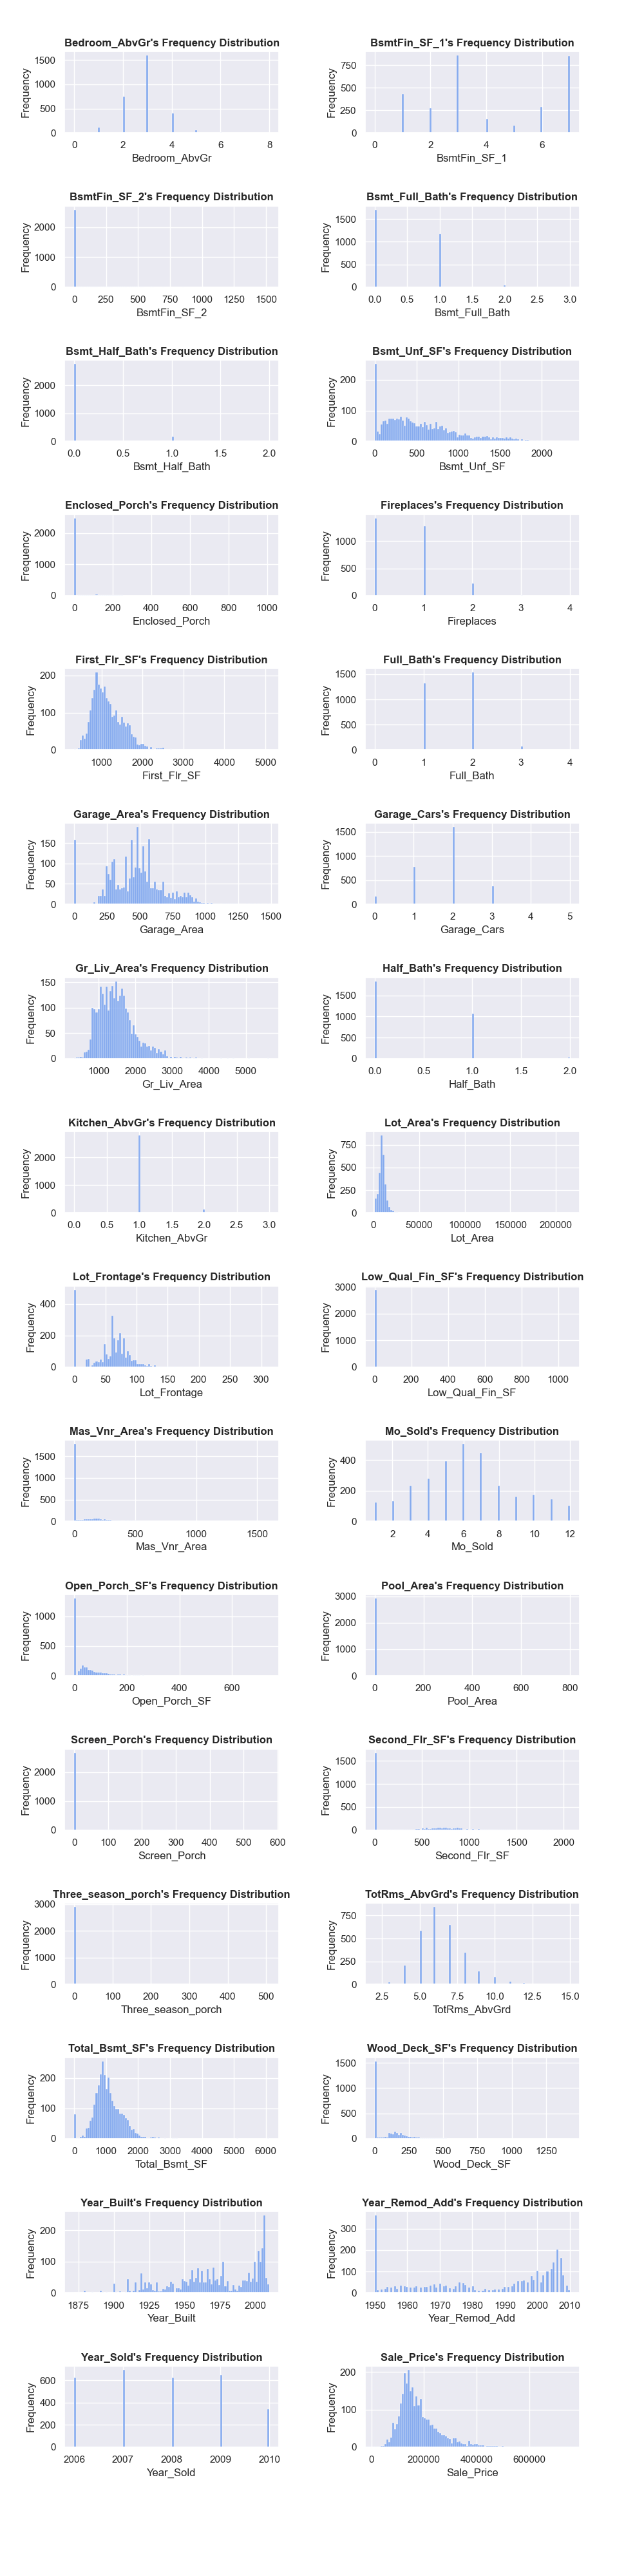

In [135]:
def plot_frequency_distr_numeric(dataset, exclude_abs=False, include_kde=False, plot_cols=2, notebook_fig_size=None, adjust=None):
    """
    Given a dataset, it plots the frequency distributions of its numeric features through histograms from seaborn
    :param exclude_abs: if True, ignores the rows which take 0 as value for a particular column
    :param include_kde: boolean representing whether to include kde
    :param dataset: pandas dataframe
    :param plot_cols: count of plots per column
    :param notebook_fig_size: dictionary of integers including keys 'width', 'height' which represent the measures in inches for notebook display purposes
    :param adjust: dictionary of float including keys 'left', 'right', 'top', 'bottom', 'wspace', 'hspace' which are used to space the different plots between them
    """
    # Numeric dataframe
    num_df = dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    
    # Set subplot shape
    fig, axes = plt.subplots(nrows = int(np.ceil(num_df.shape[1]/plot_cols)), ncols = plot_cols)
    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()
    
    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(10, 40)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))
    
    # Plot distribution for each feature
    for ax, col in zip(axes, num_df.columns):
        if exclude_abs is False:
            sns.histplot(num_df[col], ax = ax, color='cornflowerblue', bins=100, kde=include_kde)
        else:
            sns.histplot(num_df[num_df[col]>0].loc[:, col], ax = ax, color='cornflowerblue', bins=100, kde=include_kde)
        ax.set_title(col+'\'s Frequency Distribution', fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        
    # Adjust spacing between plots
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.05, wspace=0.4, hspace=0.9)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

plot_frequency_distr_numeric(dataset=df.loc[:, ~df.columns.isin(['Latitude', 'Longitude'])], plot_cols=2)

We notice that even continuous aspects tend to have `0.0` to represent the absence of that particular house feature and since there are many of those, it can be hard to normalize the data.

## Categorical Features Overview

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [136]:
df.select_dtypes(object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Alley           2930 non-null   object
 1   Bldg_Type       2930 non-null   object
 2   BsmtFin_Type_1  2930 non-null   object
 3   BsmtFin_Type_2  2930 non-null   object
 4   Bsmt_Cond       2930 non-null   object
 5   Bsmt_Exposure   2930 non-null   object
 6   Bsmt_Qual       2930 non-null   object
 7   Central_Air     2930 non-null   object
 8   Condition_1     2930 non-null   object
 9   Condition_2     2930 non-null   object
 10  Electrical      2930 non-null   object
 11  Exter_Cond      2930 non-null   object
 12  Exter_Qual      2930 non-null   object
 13  Exterior_1st    2930 non-null   object
 14  Exterior_2nd    2930 non-null   object
 15  Fence           2930 non-null   object
 16  Fireplace_Qu    2930 non-null   object
 17  Foundation      2930 non-null   object
 18  Function

Before plotting categorical features, which might be unnecessary, we should look out for their meaning. In fact, categorical features have some special subcases:
* **Nominal features**, describe a name, label or category **without natural order**;
* **Ordinal features**, variables whose values are defined by an **order relation** between the different categories;

From another point of view we also can define **Dichotomous features**, categorical variables with two categories or levels;
* *Discrete Dichotomous* features, categorical variables with two categories or levels and **nothing in between them**. 
    * Binary features, variables assigned either a 0 or a 1.
* *Continuous Dichotomous* features, categorical variables **with possibilities in between** the two (extreme) categories.

The problem here is we have mix of these features which can be confusing when it is time for encoding, since the difference between ordinal features and continuous dichotomous features can be subtle.

Let us start with their frequencies

In [205]:
# We use a decoded version of the dataset to display the labels better
def decode_byte_str(dataset):
    categorical = df.select_dtypes(object)
    categorical = categorical.stack().str.decode('utf-8').unstack()
    for col in categorical:
        dataset[col] = categorical[col]
    pass

temp=df.copy()
decode_byte_str(dataset=temp)

<IPython.core.display.Javascript object>


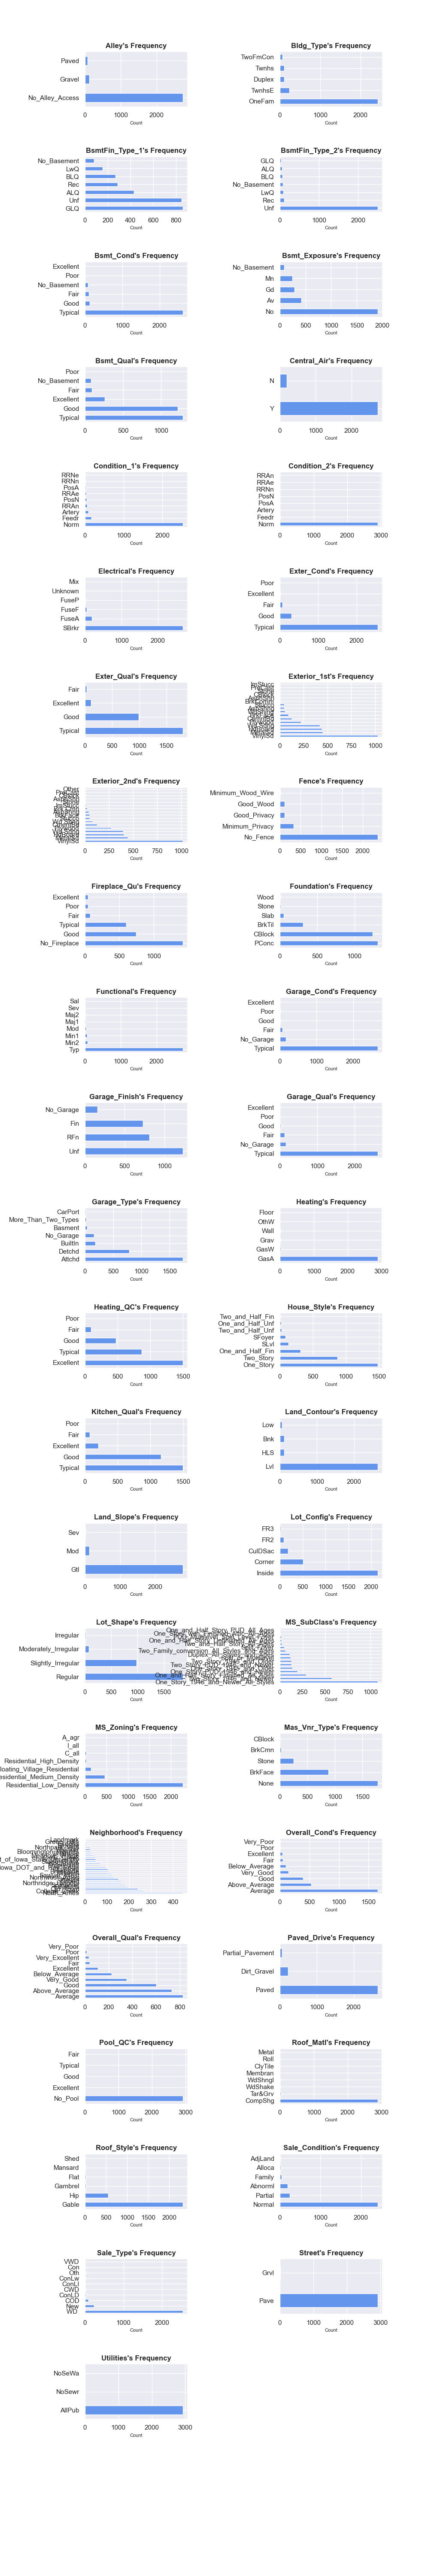

In [138]:
from itertools import zip_longest

def barplot_categ(dataset):
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (int(np.ceil(n / 2))+1, 2)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9.9, 60))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue

        ax = categorical_data[feature_name].value_counts().plot.barh(ax=ax, color='cornflowerblue')
        ax.set_title(feature_name + '\'s Frequency', fontweight='bold')
        ax.set_xlabel('Count', fontsize = 8)

    plt.subplots_adjust(left=0.2,
                    bottom=0.02,
                    right=0.9,
                    top=0.98,
                    wspace=0.9,
                    hspace=0.9)
    pass

barplot_categ(temp)

### Nominal features
These features are very easy to recognize as they give us no hint of an "order" in their levels.

We prefer to use a One-Hot encoding for these variables from which we obtain a series of binary variables (1 or 0) representing whether or not a category was present for a particular row.

In [139]:
%%html --isolated
<style type="text/css">.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style><div class="tg-wrap"><table id="tg-qpwKN" style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;margin:0px auto" class="tg"><thead><tr><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:left;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Feature</span></th><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Meaning</span></th></tr></thead><tbody><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Alley</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of alley access</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bldg_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of dwelling</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Condition_1</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Proximity to various conditions</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Condition_2</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Proximity to various conditions (if more than one is present)</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Electrical</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Electrical system</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior_1st</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior covering on house</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior_2nd</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exterior covering on house</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Foundation</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of foundation</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage location</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Heating</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of heating</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">House_Style</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Style of dwelling</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Lot_Config</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Lot Configuration</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Mas_Vnr_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Masonry veneer type</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">MS_SubClass</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Identifies the type of dwelling involved in the sale.</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">MS_Zoning</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Identifies the general zoning classification of the sale.</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Neighborhood</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Physical locations within Ames city limits</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Roof_Matl</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Roof Material</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Roof_Style</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of roof</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Sale_Condition</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Condition of sale</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Sale_Type</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of sale</td></tr></tbody></table></div><script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

Alley,Type of alley access
Bldg_Type,Type of dwelling
Condition_1,Proximity to various conditions
Condition_2,Proximity to various conditions (if more than one is present)
Electrical,Electrical system
Exterior_1st,Exterior covering on house
Exterior_2nd,Exterior covering on house
Foundation,Type of foundation
Garage_Type,Garage location
Heating,Type of heating
House_Style,Style of dwelling


### Ordinal features
As principle that guides us to classify a feature as ordinal is the usage of the words "Quality" or "Condition", and the presence of levels in between two extremes.

In certain cases, we chose not to adopt a conventional approach as some variables have most instances in a single category, which then makes that the 'average' category.

In [140]:
%%html --isolated

<style type="text/css">.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style><div class="tg-wrap"><table id="tg-oyTCE" style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;margin:0px auto" class="tg"><thead><tr><th style="background-color:#409cff;border-color:inherit;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:left;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Feature</span></th><th style="background-color:#409cff;border-color:inherit;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal"><span style="font-weight:bold">Meaning</span></th></tr></thead><tbody><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">BsmtFin_Type_1</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rating of basement finished area</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">BsmtFin_Type_2</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rating of basement finished area (if multiple types)</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bsmt_Cond</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the general condition of the basement</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bsmt_Exposure</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Refers to walkout or garden level walls</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Bsmt_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the height of the basement</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exter_Cond</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the present condition of the material on the exterior</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Exter_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Evaluates the quality of the material on the exterior</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fence</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fence quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fireplace_Qu</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fireplace quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Functional</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Home functionality (Assume typical unless deductions are warranted)</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Cond</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage condition</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Finish</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Interior finish of the garage</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Garage quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Heating_QC</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Heating quality and condition</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Kitchen_Qual</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Kitchen quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Land_Contour</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Flatness of the property</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Land_Slope</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Slope of property</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Lot_Shape</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">General shape of property</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Overall_Cond</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rates the overall condition of the house</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Overall_Qual</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Rates the overall material and finish of the house</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Paved_Drive</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Paved driveway</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Pool_QC</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Pool quality</td></tr><tr><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Utilities</td><td style="background-color:#EBF5FF;border-color:inherit;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of utilities available</td></tr></tbody></table></div><script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

BsmtFin_Type_1,Rating of basement finished area
BsmtFin_Type_2,Rating of basement finished area (if multiple types)
Bsmt_Cond,Evaluates the general condition of the basement
Bsmt_Exposure,Refers to walkout or garden level walls
Bsmt_Qual,Evaluates the height of the basement
Exter_Cond,Evaluates the present condition of the material on the exterior
Exter_Qual,Evaluates the quality of the material on the exterior
Fence,Fence quality
Fireplace_Qu,Fireplace quality
Functional,Home functionality (Assume typical unless deductions are warranted)
Garage_Cond,Garage condition


### Binary Features
Some features that can interpreted as **binary** categorical features

In [141]:
%%html --isolate

<style type="text/css">.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style><div class="tg-wrap"><table id="tg-VcE8X" style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;margin:0px auto" class="tg"><thead><tr><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:left;top:-1px;vertical-align:top;will-change:transform;word-break:normal">Feature</th><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal">Meaning</th><th style="background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;position:-webkit-sticky;position:sticky;text-align:center;top:-1px;vertical-align:top;will-change:transform;word-break:normal">Values</th></tr></thead><tbody><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Central_Air</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Central air conditioning</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">'Y', 'N'</td></tr><tr><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-style:italic;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Street</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Type of road access to property</td><td style="background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">'Grvl', 'Pave'</td></tr></tbody></table></div><script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n?n.length:0}function t(n,t,e,o=0){for(e=r(n);o<e;++o)t(n[o],o)}function e(n){return n.split("").reverse().join("")}function o(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function u(n,r,e=[]){return t(n,function(n){r(n)&&e.push(n)}),e}var a=parseFloat;function i(n,r){return function(t){var e="";return t.replace(n,function(n,t,o){return e=t.replace(r,"")+"."+(o||"").substring(1)}),a(e)}}var s=i(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),c=i(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);function f(n){var t=a(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function d(n){var e=[],o=n;return t([f,s,c],function(u){var a=[],i=[];t(n,function(n,r){r=u(n),a.push(r),r||i.push(n)}),r(i)<r(o)&&(o=i,e=a)}),r(u(o,function(n){return n==o[0]}))==r(o)?e:[]}function v(n){if("TABLE"==n.nodeName){for(var a=function(r){var e,o,u=[],a=[];return function n(r,e){e(r),t(r.childNodes,function(r){n(r,e)})}(n,function(n){"TR"==(o=n.nodeName)?(e=[],u.push(e),a.push(n)):"TD"!=o&&"TH"!=o||e.push(n)}),[u,a]}(),i=a[0],s=a[1],c=r(i),f=c>1&&r(i[0])<r(i[1])?1:0,v=f+1,p=i[f],h=r(p),l=[],g=[],N=[],m=v;m<c;++m){for(var T=0;T<h;++T){r(g)<h&&g.push([]);var C=i[m][T],L=C.textContent||C.innerText||"";g[T].push(L.trim())}N.push(m-v)}t(p,function(n,t){l[t]=0;var a=n.classList;a.add("tg-sort-header"),n.addEventListener("click",function(){var n=l[t];!function(){for(var n=0;n<h;++n){var r=p[n].classList;r.remove("tg-sort-asc"),r.remove("tg-sort-desc"),l[n]=0}}(),(n=1==n?-1:+!n)&&a.add(n>0?"tg-sort-asc":"tg-sort-desc"),l[t]=n;var i,f=g[t],m=function(r,t){return n*f[r].localeCompare(f[t])||n*(r-t)},T=function(n){var t=d(n);if(!r(t)){var u=o(n),a=o(n.map(e));t=d(n.map(function(n){return n.substring(u,r(n)-a)}))}return t}(f);(r(T)||r(T=r(u(i=f.map(Date.parse),isNaN))?[]:i))&&(m=function(r,t){var e=T[r],o=T[t],u=isNaN(e),a=isNaN(o);return u&&a?0:u?-n:a?n:e>o?n:e<o?-n:n*(r-t)});var C,L=N.slice();L.sort(m);for(var E=v;E<c;++E)(C=s[E].parentNode).removeChild(s[E]);for(E=v;E<c;++E)C.appendChild(s[v+L[E-v]])})})}}n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{v(t[e])}catch(n){}})}(document)</script>

Central_Air,Central air conditioning,"'Y', 'N'"
Street,Type of road access to property,"'Grvl', 'Pave'"


## Univariate Analysis
We perform an analysis of the features to remove outliers and normalize the data.

### Sale Price
Let us have a quick look at the Sales Prices. In order to add significance to the graph we want to use the colors to indicate the lot of area, and the markers to classify the type of neighborhood.


In [343]:
from scipy.stats import probplot


def numeric_distr_plot(dataset, label, shape):
    """
    Plots a
    :param dataset:
    :param label:
    :param shape:
    :param hue:
    :return:
    """
    # Normal Distribution fit
    (mu, sigma) = stats.norm.fit(dataset[label])

    # Feature Distribution Plot
    plt.figure(figsize=shape)
    sns.distplot(dataset[label], hist=True, kde=True, fit=stats.norm, color='cornflowerblue')
    
    # Figure labels
    plt.title(label + '\'s Distribution vs Normal Distribution', fontsize=14)
    plt.xlabel(label.title())
    plt.ylabel('Frequency in %')
    plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='upper right')
    plt.show()
    pass

def probability_plot(dataset, target):
    fig = plt.figure()
    res = stats.probplot(dataset[target], plot=plt)
    plt.show()
    pass

<IPython.core.display.Javascript object>


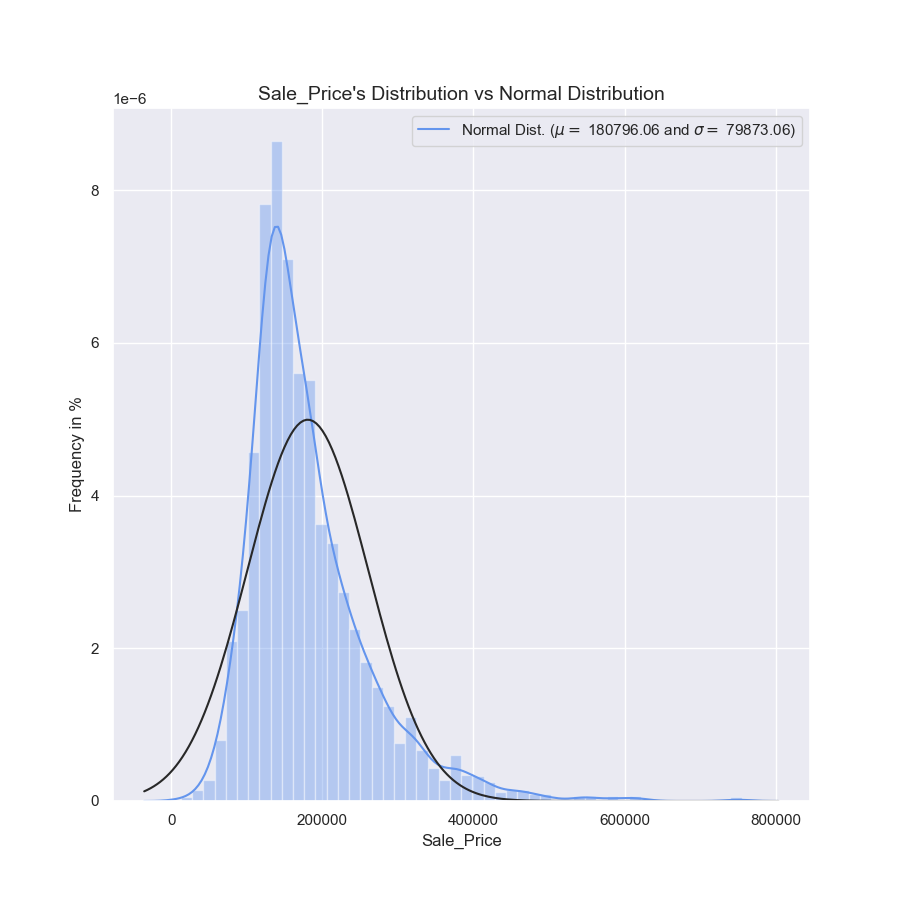

C:\Users\PayThePizzo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [344]:
numeric_distr_plot(df, 'Sale_Price', (9,9))

As we can see the sample distribution highlights quite a heavy right tail compared to the left tail. Furthermore there's evidence of outliers.

As the sample distribution looks like a log-normal distribution let's try and apply a transformation to the target.

<IPython.core.display.Javascript object>


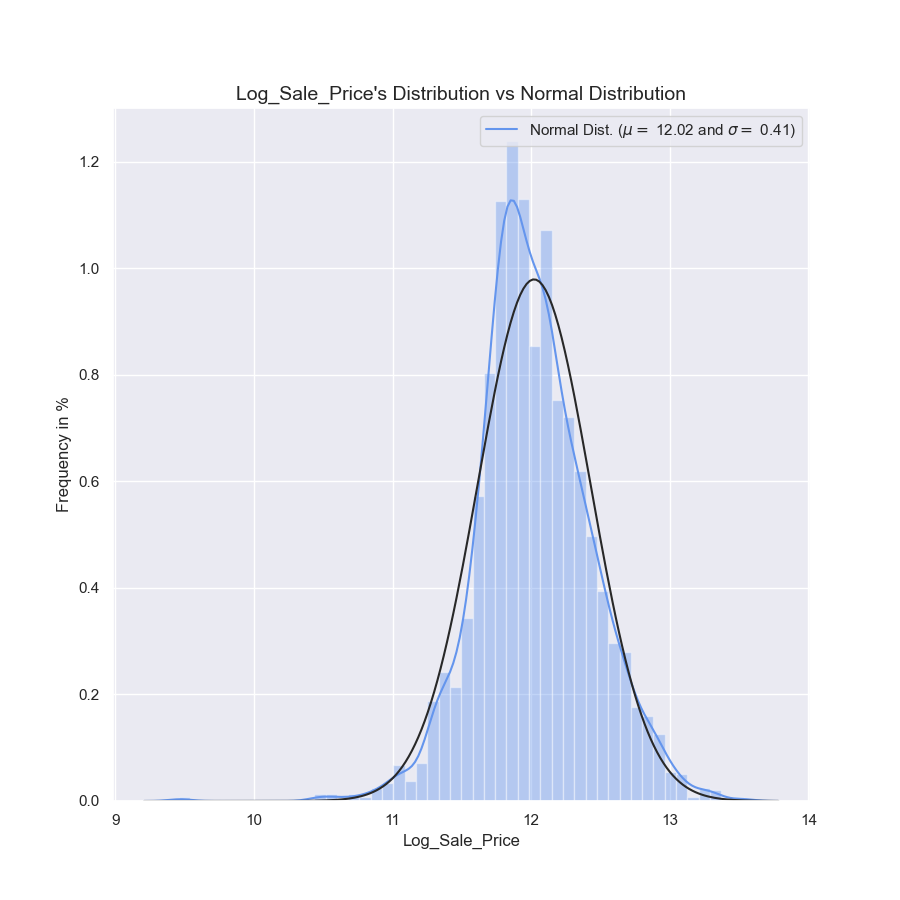

C:\Users\PayThePizzo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [345]:
# Adding Log Sale Price
df['Log_Sale_Price'] = np.log1p(df['Sale_Price'])
numeric_distr_plot(df, 'Log_Sale_Price', (9,9))

As we can see, the target log-transformation is almost centered around the sample mean $\mu = 12$

Let us investigate the outliers

In [346]:
def scatterplot_distr(dataset, label, shape):
    plt.figure(figsize=shape)
    plt.scatter(range(dataset[label].shape[0]), np.sort(dataset[label].values))
    plt.title(label + '\'s Scatter Plot')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.show()
    pass

<IPython.core.display.Javascript object>


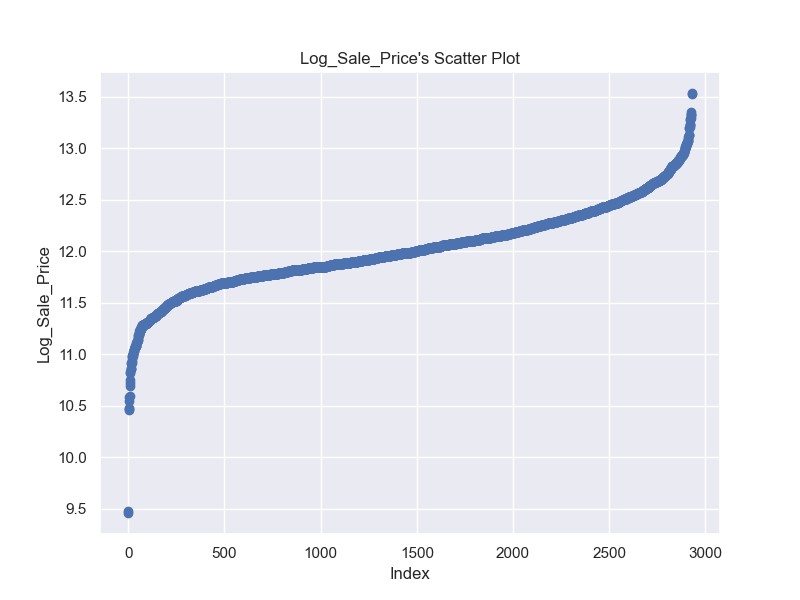

In [347]:
scatterplot_distr(df, 'Log_Sale_Price', shape=(8,6))

We can see that the transformation has highlighted some influential instances which might be problematic and we want to save them to understand whether they are possible outliers.

In [348]:
outliers = df[(df['Log_Sale_Price']>13.4) | (df['Log_Sale_Price']<9.5)]

Let us look at the distribution without those outliers

<IPython.core.display.Javascript object>


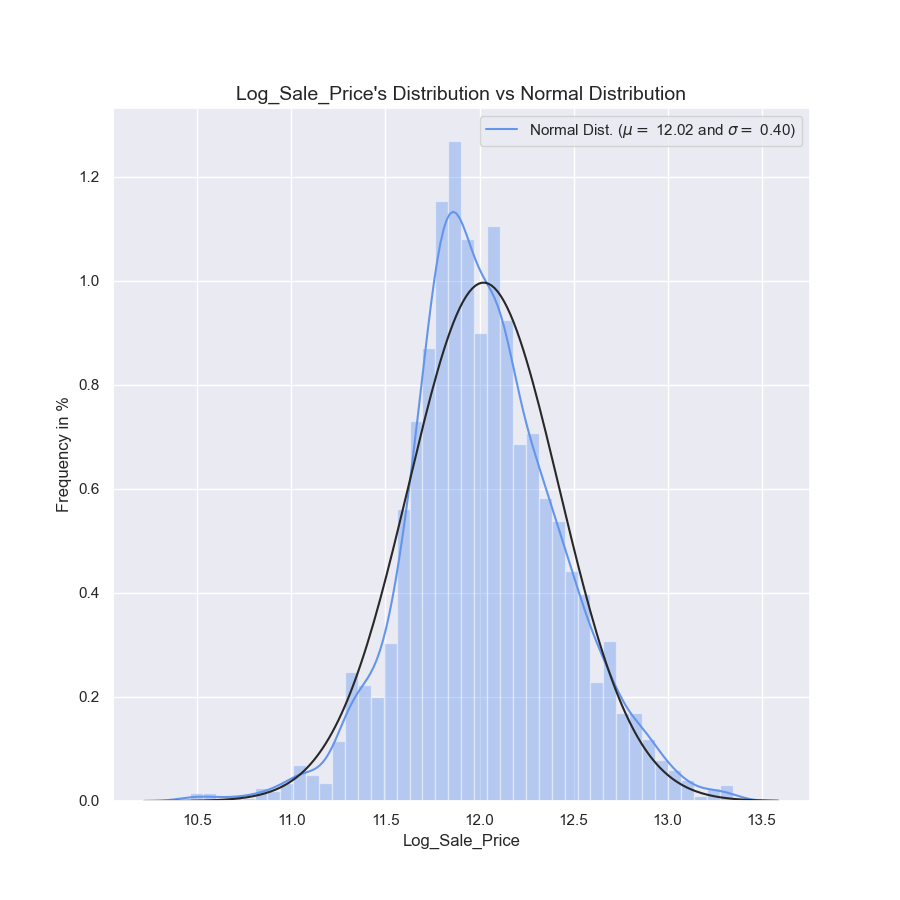

C:\Users\PayThePizzo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [350]:
numeric_distr_plot(df.drop(outliers.index), 'Log_Sale_Price', (9,9))

<IPython.core.display.Javascript object>


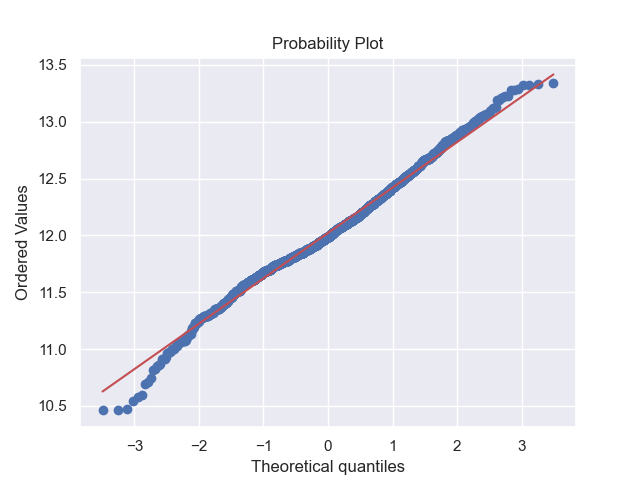

In [351]:
probability_plot(dataset=df.drop(outliers.index), target = 'Log_Sale_Price')

The skew now tends to be on the left side. We will try and adjust that later

### Lot Area

<IPython.core.display.Javascript object>


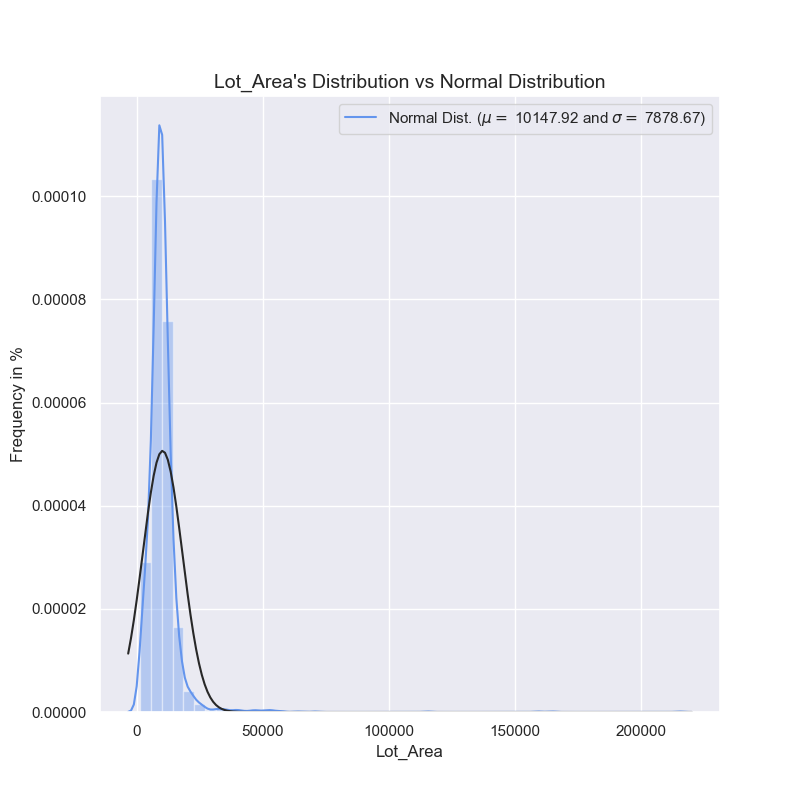

C:\Users\PayThePizzo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [352]:
numeric_distr_plot(df, 'Lot_Area', (8,8))

<IPython.core.display.Javascript object>


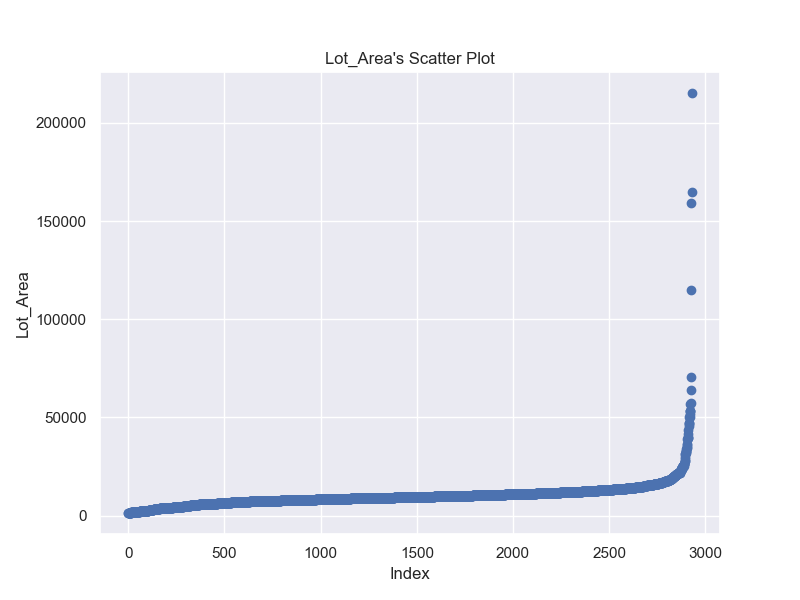

In [353]:
scatterplot_distr(df, 'Lot_Area', shape=(8,6))

Again here we find some outliers which are no good.

In [354]:
outliers=outliers.append(df[(df['Lot_Area']>100000)])

<IPython.core.display.Javascript object>


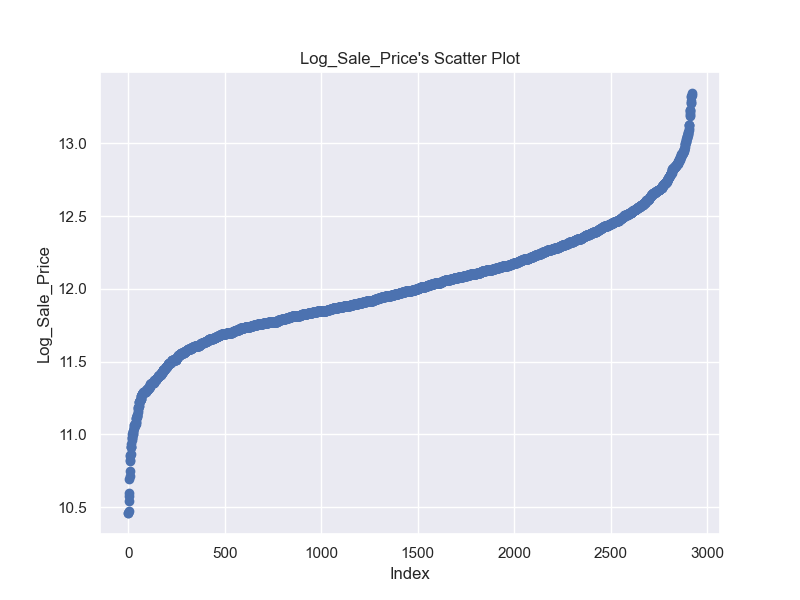

In [355]:
scatterplot_distr(df.drop(outliers.index).reset_index(), 'Log_Sale_Price', shape=(8,6))

Definitely better!

## Bivariate Analysis
Before choosing what features to inspect in depth, we look at the correlation and we discard the outliers.

### Correlation

In [246]:
def display_corr_matrix(dataset, label):
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))

    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)

    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix

In [251]:
def top_correlated_features(corr_matrix, label, threshold=0.45):
    m = corr[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict

<IPython.core.display.Javascript object>


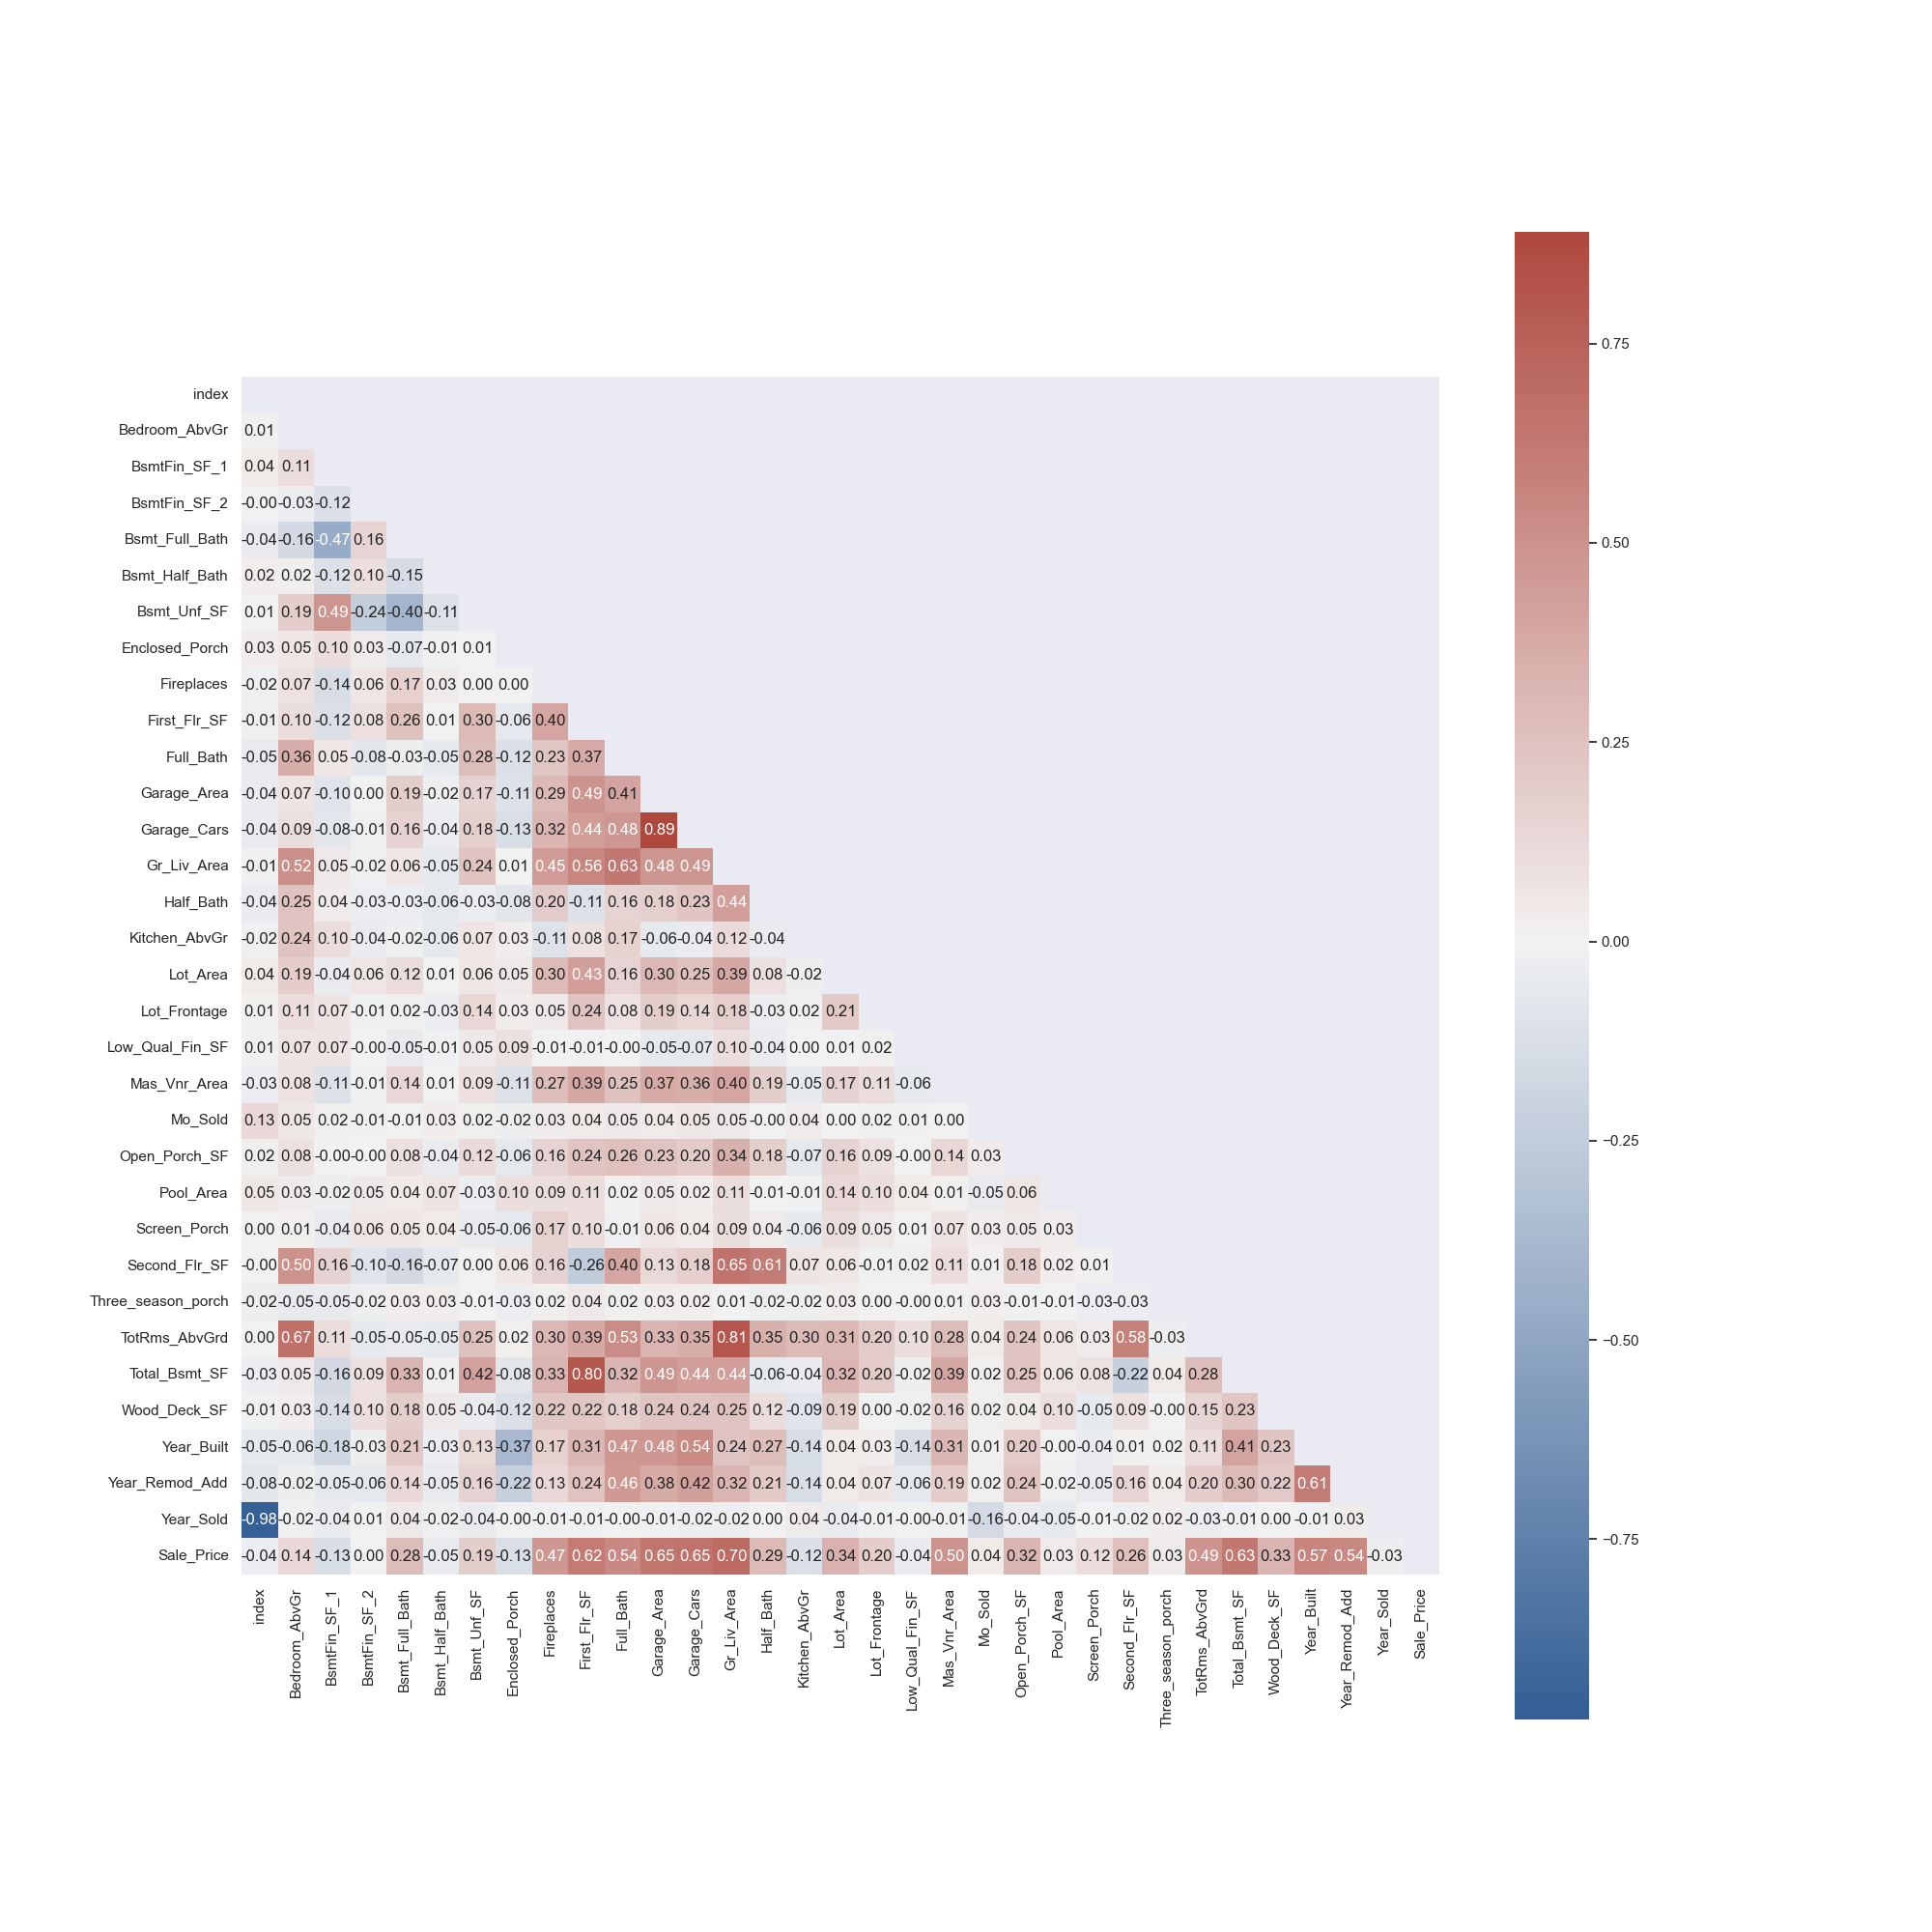

In [252]:
corr = display_corr_matrix(dataset=(df.loc[:, ~df.columns.isin(['Latitude', 'Longitude', 'Log_Sale_Price'])]).drop(outliers.index).reset_index(), label='Sale_Price')

In [253]:
top_corr_dict = top_correlated_features(corr, 'Sale_Price', 0.45)
top_corr_dict

{'Gr_Liv_Area': 0.6981151005527915,
 'Garage_Cars': 0.6537268900241814,
 'Garage_Area': 0.6470342017468301,
 'Total_Bsmt_SF': 0.628572953183459,
 'First_Flr_SF': 0.6174707353736213,
 'Year_Built': 0.56560409151366,
 'Full_Bath': 0.5428894649038042,
 'Year_Remod_Add': 0.5407120160995234,
 'Mas_Vnr_Area': 0.5011494772903987,
 'TotRms_AbvGrd': 0.4936762768542194,
 'Fireplaces': 0.47167179351375427}

Now that we saw what features are highly correlated with Sale_Price, we will take a closer look at them.:
* `Gr_Liv_Area`
* `Garage_Cars`
* `Garage_Area`
* `Total_Bsmt_SF`
* `First_Flr_SF`
* `Year_Built`
* `Full_Bath`
* `Year_Remod_Add`
* `Mas_Vnr_Area`
* `TotRms_AbvGrd`
* `Fireplaces`

Moreover, we know from domain research that some important aspects are
* Lot Area
* Year and Month of Sale
* Neighborhood

Finally, we shall look at the categorical features too in a second moment.

We must pay attention to the ones who show collinearity as they might disturb our prediction. We should investigate the relationships of high correlation between other variables:

In [274]:
# corr.loc[corr.columns.isin(list(top_corr_dict.keys())), corr.columns.isin(list(top_corr_dict.keys()))]

,Fireplaces,First_Flr_SF,Full_Bath,Garage_Area,Garage_Cars,Gr_Liv_Area,Mas_Vnr_Area,TotRms_AbvGrd,Total_Bsmt_SF,Year_Built,Year_Remod_Add
Fireplaces,1.000000,0.401329,0.225357,0.292537,0.320247,0.451556,0.267590,0.300957,0.327705,0.171291,0.132976
First_Flr_SF,0.401329,1.000000,0.366788,0.490675,0.438357,0.556917,0.390241,0.387055,0.798420,0.310375,0.242114
Full_Bath,0.225357,0.366788,1.000000,0.405671,0.476022,0.628045,0.251298,0.526538,0.320195,0.469277,0.457472
Garage_Area,0.292537,0.490675,0.405671,1.000000,0.890044,0.484916,0.370778,0.326905,0.485619,0.481752,0.376293
Garage_Cars,0.320247,0.438357,0.476022,0.890044,1.000000,0.488030,0.356725,0.354415,0.437237,0.538391,0.424977
Gr_Liv_Area,0.451556,0.556917,0.628045,0.484916,0.488030,1.000000,0.396937,0.809641,0.437701,0.241143,0.317886
Mas_Vnr_Area,0.267590,0.390241,0.251298,0.370778,0.356725,0.396937,1.000000,0.277007,0.391723,0.307769,0.190517
TotRms_AbvGrd,0.300957,0.387055,0.526538,0.326905,0.354415,0.809641,0.277007,1.000000,0.277071,0.110396,0.196984
Total_Bsmt_SF,0.327705,0.798420,0.320195,0.485619,0.437237,0.437701,0.391723,0.277071,1.000000,0.408300,0.298346
Year_Built,0.171291,0.310375,0.469277,0.481752,0.538391,0.241143,0.307769,0.110396,0.408300,1.000000,0.612319


In [311]:
def display_collinearity(sample_dict):
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

display_collinearity(top_corr_dict)
    

Top correlated features with "Gr_Liv_Area"
	TotRms_AbvGrd : 0.8096414892147159
	Sale_Price : 0.6981151005527915
	Second_Flr_SF : 0.6514895508859291
	Full_Bath : 0.6280450222862795


Top correlated features with "Garage_Cars"
	Garage_Area : 0.8900437080313784
	Sale_Price : 0.6537268900241814


Top correlated features with "Garage_Area"
	Garage_Cars : 0.8900437080313784
	Sale_Price : 0.6470342017468301


Top correlated features with "Total_Bsmt_SF"
	First_Flr_SF : 0.7984196825536917
	Sale_Price : 0.628572953183459


Top correlated features with "First_Flr_SF"
	Total_Bsmt_SF : 0.7984196825536917
	Sale_Price : 0.6174707353736213


Top correlated features with "Year_Built"
	Year_Remod_Add : 0.6123185869846453


Top correlated features with "Full_Bath"
	Gr_Liv_Area : 0.6280450222862795


Top correlated features with "Year_Remod_Add"
	Year_Built : 0.6123185869846453


Top correlated features with "Mas_Vnr_Area"


Top correlated features with "TotRms_AbvGrd"
	Gr_Liv_Area : 0.8096414892147159
	

In [318]:
def lmplot_single(dataset, target, label, hue=None):
    sns.lmplot(data=dataset, x=target, y=label, aspect=1.5, scatter=True, hue=hue)
    pass

In [321]:
def lmplot_multiple(dataset, target, labels, plot_cols=1, notebook_fig_size=None, adjust=None, hue=None):

#     fig, axes = plt.subplots(nrows = int(np.ceil(len(labels)/plot_cols)), ncols = plot_cols)

#     # Flat 1-D flat iterator over the array.
#     axes = axes.flatten()

    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(9, 40)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))

    # Plot 
    for col in dataset.loc[:, dataset.columns.isin(labels)].columns:
        sns.lmplot(data=dataset, x=target, y=col, scatter=True, aspect=1.5, hue=hue)
        ax.set_title(col + " vs " + target, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel(target)

    # Adjust 
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.05, wspace=0.4, hspace=0.9)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

### Lot Area vs Price

<IPython.core.display.Javascript object>


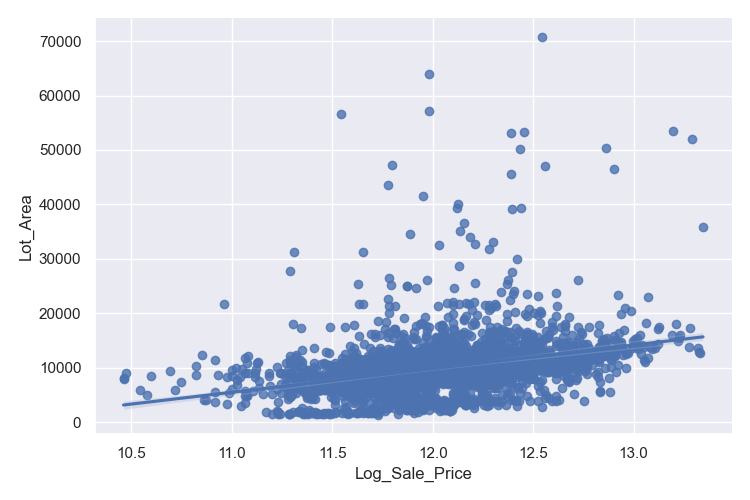

In [330]:
lmplot_single(df.drop(outliers.index).reset_index(),'Log_Sale_Price', 'Lot_Area')

It looks acceptable, although we have some problematic points

In [ ]:
# Remove outliers

https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

### Internal Area vs Price
* Inside of the house
* Above Ground
* Basement

### Garage vs Price
* Area
* Cars

<IPython.core.display.Javascript object>


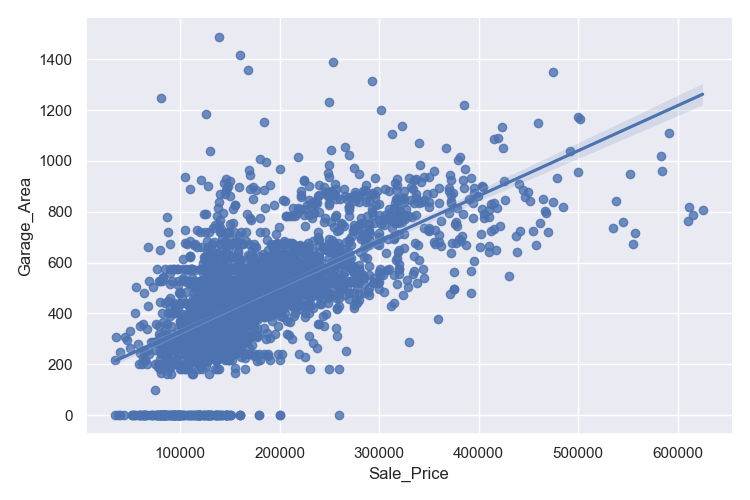

In [325]:
lmplot_single(df.drop(outliers.index).reset_index(), target='Sale_Price', label='Garage_Area')

## Location
We want to see how the 


### Neighborhood

Let us see if the price is influenced by neighborhood

In [ ]:
# Price for each neighboorhood
sns.set_theme(style="ticks", palette="pastel")
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Neighborhood", y="Sale_Price", palette=["m", "g"],
            data= df)
sns.despine(offset=10, trim=True)
plt.show()

### Street Proximity

In [ ]:
sns.

We can see the data is slightly skewed with a longer right wing

### Seasonality
https://www.bankrate.com/real-estate/best-time-to-sell-house/

We can easily see that the houses were sold between 2006 and 2010. This means it includes trends of the global state of the economy during the crisis in 2008

We can divide the years by seasons:
1. December-March
2. April-July, which are supposed to be the best time for selling
3. August-November

In [ ]:
# Seasons for sales
seasons_dict = {
    'DecMar': [12,1,2,3],
    'AprJul': [4,5,6,7],
    'AugNov': [8,9,10,11]
}

def select_sort_by_col(dataset, list_of_cols):
    """
    Returns a subset of the input dataset, where the rows are sorted by the columns given
    :param dataset: pandas dataframe
    :param list_of_cols: list of strings with col labels
    :return: dataframe
    """
    return dataset[list_of_cols].sort_values(by = list_of_cols)


# A subset sorted by values, where yr and mo are converted to integers
df_yr_mo = select_sort_by_col(df, ['Year_Sold', 'Mo_Sold', 'Sale_Price']).astype(dtype={ 'Year_Sold' : 'int32', 'Mo_Sold' : 'int32'})
df_yr_mo

In [ ]:
def divide_by_seasonality():
    #data structure
    year_stats = []
    for x in range(2006, 2010):
        year_x = time_df.loc[time_df.Year_Sold == x]
        mean = year_x.Sale_Price.mean()
        median = year_x.Sale_Price.median()
        second_quant = year_x.Sale_Price.quantile(q=0.25)
        third_quant = year_x.Sale_Price.quantile(q=0.75)
        # Save info by season
        for y in range (1, 12):
            if y in [1,2,3,12]:

            else if y in [4, 5, 6, 7]:

            else if y in [8, 9, 10, 11]:

        year_stats.append([x, mean, median, second_quant, third_quant])

    return year_stats

mystats = divide_by_seasonality()

plt.hist()

# Result array of 15 elements
# each element with mean, median, min, max

In [ ]:
sns.scatterplot(data=df, x='Sale_Price', y='Year_Sold')

In [ ]:
mystats

# Multivariate Analysis

# Clustering for distance
We will try and cluster the houses:
1. Find Neighborhood and asses mean price
2. In each Neighborhood, For each house
   * Compare how the change in one important features translates in change in price


# Categorical Data Encoding

# Feature Engineering

Based on domain knowledge & Feature importance
Dropping outliers
1. Age
2. Epoch (Year_Sold + Month_Sold)
4. Price/SqFT
5. Total Ext SqFT (Porch + Deck)

In [ ]:
import datetime

df['Age'] = int(datetime.datetime.now().year) - df['Year_Built']
df['Age_Since_Remod'] = int(datetime.datetime.now().year) - df['Year_Remod_Add']
df['Price_per_SqFt'] = df['Sale_Price']/df['Lot_Area']
df['Ext_SqFt'] = df['Wood_Deck_SF'] + df['Open_Porch_SF'] + df['Screen_Porch'] + df['Enclosed_Porch'] + df['Three_season_porch']

df

### Analysis of new features

# Data Cleaning

## Data Coherence

From the first graphs we plotted, we could tell that many instances contained `0.0`. This could lead to two hypothesis
* All the NaN or missing values where replaced with 0;
* Those house are really missing those features;

However, this is problematic as those points are influential for our estimations.

In [ ]:

def calc_percent_missing(df):
    nan_percent = {col : df[col].isnull().mean() for col in df.columns}
    return nan_percent

nan_percent = calc_percent_missing(data)
nan_percent = pd.DataFrame(sorted(nan_percent.items(), key=lambda x: x[1], reverse=True))
nan_percent = nan_percent[nan_percent[1] >= 0.005]

plt.figure(figsize=(24, 6))
sns.barplot(x=nan_percent[0], y=nan_percent[1] * 100)
plt.title("Percentage of missing values in data")
plt.ylabel("Percentage %")
plt.xticks(rotation=90)

In [ ]:
df.drop(labels=['Wood_Deck_SF', 'Open_Porch_SF', 'Screen_Porch', 'Enclosed_Porch', 'Year_Built', 'Latitude', 'Longitude'], axis=1, inplace=True)
df

# Data Normalization and Rescaling

# Assessing Feature Importance

## Correlation

In [ ]:
def display_corr_matrix(dataset, label):
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))

    matrix = dataset.corr()
    # Create a custom diverging palette
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)

    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    pass

display_corr_matrix(dataset=df.loc[:, ~df.columns.isin(['Latitude', 'Longitude'])], label='Sale_Price')

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

def xgb_topfeatures(dataset):

    #Object Encoding
    for f in dataset.columns:
        if dataset[f].dtype == 'object':
            labeler = LabelEncoder()
            labeler.fit(list(dataset[f].values))
            dataset[f] = labeler.transform(list(dataset[f].values))

    #Inf values are as unhelpful as missing data, so we are going to substitute them as such.
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    train_y = dataset['Price_Sale'].values
    # Drop the features that may overfit the data
    df_assess = dataset.drop(['parcelid', 'logerror', 'transaction_date', 'type_property', 'type_county_land'], axis=1)
    df_assess = rescale_data_xgb(df_assess, df_assess.columns.values)
    # Drop the features that may overfit the data
    x_train = dataset.drop(["parcelid", "transaction_date", "logerror",'type_property', 'type_county_land'], axis=1)

    #Params
    xgb_params = {
        'eta': 0.05,
        'max_depth': 8,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 0
    }

    df_train = xgb.DMatrix(df_assess, train_y, feature_names=x_train.columns.values)
    model_xgb = xgb.train(dict(xgb_params), df_train, num_boost_round=150)
    return model_xgb


def plot_top_features(xgb_model):
    feature_importance = xgb_model.get_fscore()
    top_features = pd.DataFrame()
    top_features['features'] = feature_importance.keys()
    top_features['importance'] = feature_importance.values()
    top_features.sort_values(by=['importance'],ascending=False,inplace=True)

    fig,ax= plt.subplots()
    fig.set_size_inches(20,20)
    plt.xticks(rotation=90)
    sns.barplot(data=top_features.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")
    return top_features

model = xgb_topfeatures(df)

features = plot_top_features(model)

In [ ]:
def plot_top_features(xgb_model):
    feature_importance = xgb_model.get_fscore()
    top_features = pd.DataFrame()
    top_features['features'] = feature_importance.keys()
    top_features['importance'] = feature_importance.values()
    top_features.sort_values(by=['importance'],ascending=False,inplace=True)

    fig,ax= plt.subplots()
    fig.set_size_inches(20,20)
    plt.xticks(rotation=90)
    sns.barplot(data=top_features.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")
    return top_features

In [ ]:
model = xgb_topfeatures(df)

In [ ]:
features = plot_top_features(model)

### Correlation between most important features

In [ ]:
topf = features["features"].tolist()[:20]

def top_features_corr(topFeatures):
    corrMatt = data2016[topFeatures].corr()
    mask = np.array(corrMatt)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True)
    pass

top_features_corr(topf)

### Conclusions
We now combine the results from XGBoost and our domain research to keep the most important features and assess an error percentage.

## Assessing & Dropping Outliers

In [ ]:
def plot_target_distr(dataset):
    plt.figure(figsize=(8,6))
    plt.scatter(range(dataset.shape[0]), np.sort(dataset.Sale_Price.values))
    plt.xlabel('index', fontsize=12)
    plt.ylabel('Sale Price', fontsize=12)
    plt.show()
    pass

plot_target_distr(df)

In [ ]:
# Analyze outliers

In [ ]:
# TODO: Remove outliers for price and for each column that we kept
def drop_outliers(dataset, feature, min, max):
    outliers = dataset[~dataset[feature].between(min,max)]
    dataset.drop(index = outliers.index, inplace= True)
    pass

drop_outliers(data2016, 'Sale_Price', -2.5, 3.6)

## Encoding Categorical Data

## Dropping Unhelpful Features

## Scaling & Normalization

# Pre-Training Overview
* Model Data
* Show Graphs

# Preparing Train-Test Data

In [ ]:
#test
df_train = df.loc[: , ["Mo_Sold", "Year_Sold",
             "Lot_Frontage", "Lot_Area", "Year_Built", "Total_Bsmt_SF", "First_Flr_SF", 
             "Second_Flr_SF", "Full_Bath", "Half_Bath", "Gr_Liv_Area", "Bsmt_Full_Bath", 
             "Bsmt_Half_Bath", "Bedroom_AbvGr", "Kitchen_AbvGr", "TotRms_AbvGrd", 
             "Fireplaces", "Garage_Cars", "Garage_Area", "Wood_Deck_SF", 
             "Open_Porch_SF", "Enclosed_Porch", "Three_season_porch", "Screen_Porch",
            "Pool_Area"]]

df_target = df.loc[: , ['Sale_Price']]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#Split 60/20/20
X_train_80, X_test, y_train_80, y_test = train_test_split(df_train, df_target,
                                                          test_size = 0.20, random_state = 33)

X_train, X_valid, y_train, y_valid  = train_test_split(X_train_80, y_train_80, 
                                                       test_size=0.25, random_state=42)

accuracies = []

for c in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    # train and predict
    model = SVC(C=c, kernel='poly')
    model.fit(X_train, y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true = y_train, 
                               y_pred = model.predict(X_train))
    valid_acc = accuracy_score(y_true = y_valid, 
                               y_pred = model.predict(X_valid))
    print ("C: {:8.3f} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}"
           .format( c, train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, c] ]

best_accuracy, best_c = max(accuracies)
print ( "Best C:", best_c )

# here we are using both training and validation,
# to exploit the most data
model = SVC(C=best_c, kernel='poly')
model.fit(X_train_80,y_train_80)

test_acc = accuracy_score(y_true = y_test, 
                          y_pred = model.predict(X_test) )
print ("Test Accuracy: {:.3f}".format(test_acc) )

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X_train_80, X_test, y_train_80, y_test = train_test_split(df_train, df_target,
                                                          test_size = 0.20, random_state = 42)

model = SVC()
parameters = { 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
        
tuned_model = GridSearchCV(model, parameters, cv=5, verbose=0)
tuned_model.fit(X_train_80, y_train_80)

print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print ("Best Params: ", tuned_model.best_params_)

In [ ]:
tuned_model.cv_results_

In [ ]:
pd.DataFrame( tuned_model.cv_results_ )

In [ ]:
test_acc = accuracy_score(y_true = y_test, 
                          y_pred = tuned_model.predict(X_test) )
print ("Test Accuracy: {:.3f}".format(test_acc) )

# Prediction - Bagged Random Forest

## Parameter Tuning

## Precision Evaluation & Diagnostics

# Prediction - ANN

## Parameter Tuning

## Precision Evaluation & Diagnostics

# Conclusions
Results
1. Price = Sum(Important Features) + Error
    * Error = Sum(Less Important Feature)
2. Price = Sum(Feature Block + Error)

# Credits & Copyright

Domain Knowledge
 
 @misc{johnson_2022, title={4 best ways to determine home value}, url={https://www.rocketmortgage.com/learn/home-value}, journal={Rocket Mortgage}, author={Johnson, Jamie}, year={2022}, month={Sep}} 
 
  @misc{gomez_2022, title={8 critical factors that influence a home's value}, url={https://www.opendoor.com/w/blog/factors-that-influence-home-value}, journal={Opendoor}, author={Gomez, Joe}, year={2022}, month={Aug}} 
 
Quote bibtex
 https://www.youtube.com/watch?v=m3o1KXA1Rjk
 https://www.bibme.org/
 


### TODO
* Check for plagiarism
* Rephrase

In [ ]:
has_pool = df.loc[df.Pool_Area > 0.0]